In [24]:
MODELS_FROM_FILE = 0
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score, r2_score, mean_absolute_error
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)
pd.set_option('precision', 2)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

# Prepare input and ouptut column names

output_cols = [x for x in item_lvl_w_imp.columns if x.startswith("WIAT") or x.startswith("WISC")] # All WISC and WIAT columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC

# Separate test set for all output columns

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

[print(x) for x in val_set.columns]

Basic_Demos,Age
Basic_Demos,Sex
NIH_Scores,NIH7_Card
NIH_Scores,NIH7_Complete
NIH_Scores,NIH7_Flanker
NIH_Scores,NIH7_List
NIH_Scores,NIH7_Pattern
WIAT,WIAT_Num_Stnd
WIAT,WIAT_Word_Stnd
SympChck,CSC_01C
SympChck,CSC_01P
SympChck,CSC_02C
SympChck,CSC_02P
SympChck,CSC_03C
SympChck,CSC_03P
SympChck,CSC_04C
SympChck,CSC_04P
SympChck,CSC_05C
SympChck,CSC_05P
SympChck,CSC_06C
SympChck,CSC_06P
SympChck,CSC_07C
SympChck,CSC_07P
SympChck,CSC_08C
SympChck,CSC_08P
SympChck,CSC_09C
SympChck,CSC_09P
SympChck,CSC_10C
SympChck,CSC_10P
SympChck,CSC_11C
SympChck,CSC_11P
SympChck,CSC_12C
SympChck,CSC_12P
SympChck,CSC_13C
SympChck,CSC_13P
SympChck,CSC_14C
SympChck,CSC_14P
SympChck,CSC_15C
SympChck,CSC_15P
SympChck,CSC_16C
SympChck,CSC_16P
SympChck,CSC_17C
SympChck,CSC_17P
SympChck,CSC_18C
SympChck,CSC_18P
SympChck,CSC_19C
SympChck,CSC_19P
SympChck,CSC_20C
SympChck,CSC_20P
SympChck,CSC_21C
SympChck,CSC_21P
SympChck,CSC_22C
SympChck,CSC_22P
SympChck,CSC_23C
SympChck,CSC_23P
SympChck,CSC_24C
SympChck,CSC_24

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [25]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    svr = svm.SVR()
    en = ElasticNet()
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svr_pipe = make_pipeline(imputer, scaler, svr)
    en_pipe = make_pipeline(imputer, scaler, en)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeregressor__splitter": ["best","random"],
        "decisiontreeregressor__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeregressor__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeregressor__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeregressor__max_leaf_nodes": np.random.randint(2, 50, 30)
    }
    rf_param_grid = {
        'randomforestregressor__max_depth': np.random.randint(5, 150, 30),
        'randomforestregressor__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestregressor__n_estimators': np.random.randint(50, 400, 10),
        'randomforestregressor__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0]
    }
    svr_param_grid = {
        'svr__C': loguniform(1e-03, 1e+02),
        'svr__gamma': loguniform(1e-03, 1e+02),
        'svr__degree': uniform(2, 5),
        'svr__epsilon': loguniform(1e-03,1),
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    en_param_grid = {
        'elasticnet__alpha': loguniform(1e-5, 100),
        'elasticnet__l1_ratio': uniform(0, 1)
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svr_pipe, svr_param_grid),
        (en_pipe, en_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_estimator(base_model, grid, output_col):
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=3, scoring="r2", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    return (best_estimator, best_score)

In [26]:
def find_best_estimator_for_output(output_col):
    base_models_and_param_grids = get_base_models_and_param_grids()
    best_estimators_and_scores = []
    for (base_model, grid) in base_models_and_param_grids:
        best_estimator_for_model, best_score_for_model = get_best_estimator(base_model, grid, output_col)
        model_type = list(base_model.named_steps.keys())[-1]
        best_estimators_and_scores.append([model_type, best_estimator_for_model, best_score_for_model])
       
    best_estimators_and_scores = pd.DataFrame(best_estimators_and_scores, columns = ["Model type", "Best estimator", "Best score"])
    display(best_estimators_and_scores)
    best_estimator = best_estimators_and_scores.sort_values("Best score", ascending=False)["Best estimator"].iloc[0]
    
    # If LinearRegression is not much worse than the best model, prefer LinearRegression (much faster than rest)
    best_base_model = best_estimators_and_scores[best_estimators_and_scores["Best estimator"] == best_estimator]["Model type"].iloc[0]
    if best_base_model != "elasticnet":
        best_score = best_estimators_and_scores[best_estimators_and_scores["Best estimator"] == best_estimator]["Best score"].iloc[0]
        lr_score = best_estimators_and_scores[best_estimators_and_scores["Model type"] == "elasticnet"]["Best score"].iloc[0]
        print("lr_score: ", lr_score, "; best_score: ", best_score)
        e = 0.03
        if best_score - lr_score <= e:
            best_estimator = best_estimators_and_scores[best_estimators_and_scores["Model type"] == "elasticnet"]["Best estimator"].iloc[0]
    
    return best_estimator

In [27]:
if MODELS_FROM_FILE == 0:
    best_estimators = {}
    for output in output_cols:
        best_estimator_for_output = find_best_estimator_for_output(output)
        best_estimators[output] = best_estimator_for_output
        print("Best estimator for ", output, ": ", best_estimators[output])

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.602e+02, tolerance: 2.234e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.789e+02, tolerance: 2.029e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.113e+01, tolerance: 1.899e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.650e+01, tolerance: 2.234e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.352e+02, tolerance: 2.029e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.265e+02, tolerance: 1.899e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e+02, tolerance: 2.029e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.766e+01, tolerance: 2.234e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.380e+01, tolerance: 2.234e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.183e+01, tolerance: 2.029e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e+03, tolerance: 2.029e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.536e+03, tolerance: 2.234e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Model type  \
0  decisiontreeregressor   
1  randomforestregressor   
2                    svr   
3             elasticnet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

lr_score:  0.3713535476465752 ; best_score:  0.37422059789563694
Best estimator for  WIAT,WIAT_Num_Stnd :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=1.0267283348834064,
                            l1_ratio=0.7139088354586167))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.736e+02, tolerance: 1.848e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+02, tolerance: 1.674e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.434e+02, tolerance: 1.739e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e+02, tolerance: 1.848e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.684e+02, tolerance: 1.674e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.759e+01, tolerance: 1.848e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.844e+01, tolerance: 1.848e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e+02, tolerance: 1.674e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e+02, tolerance: 1.674e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e+02, tolerance: 1.848e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+01, tolerance: 1.674e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.819e+01, tolerance: 1.674e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Model type  \
0  decisiontreeregressor   
1  randomforestregressor   
2                    svr   
3             elasticnet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Best estimator for  WIAT,WIAT_Word_Stnd :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.6062712738187332,
                            l1_ratio=0.6485075302130654))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+01, tolerance: 6.129e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.777e+00, tolerance: 5.945e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+01, tolerance: 5.945e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e+01, tolerance: 6.129e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e+01, tolerance: 6.367e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.303e+00, tolerance: 5.945e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.258e+00, tolerance: 6.129e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.755e+00, tolerance: 5.945e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e+01, tolerance: 6.367e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e+01, tolerance: 6.129e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Model type  \
0  decisiontreeregressor   
1  randomforestregressor   
2                    svr   
3             elasticnet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Best estimator for  WISC,WISC_Coding_Scaled :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.19043007546785803,
                            l1_ratio=0.7866205492590213))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.291e+01, tolerance: 1.692e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.035e+01, tolerance: 1.778e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.271e+02, tolerance: 1.648e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e+02, tolerance: 1.778e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.083e+02, tolerance: 1.648e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.581e+01, tolerance: 1.778e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e+02, tolerance: 1.692e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.771e+02, tolerance: 1.778e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+02, tolerance: 1.648e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.319e+01, tolerance: 1.778e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.390e+01, tolerance: 1.648e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.521e+02, tolerance: 1.778e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Model type  \
0  decisiontreeregressor   
1  randomforestregressor   
2                    svr   
3             elasticnet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Best estimator for  WISC,WISC_FSIQ :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.6770086597105176,
                            l1_ratio=0.9641166586427644))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.264e+00, tolerance: 5.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+00, tolerance: 5.962e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+01, tolerance: 5.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+01, tolerance: 5.962e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+01, tolerance: 5.962e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.990e+00, tolerance: 5.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+01, tolerance: 5.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.540e+00, tolerance: 5.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e+01, tolerance: 5.769e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e+01, tolerance: 5.757e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Model type  \
0  decisiontreeregressor   
1  randomforestregressor   
2                    svr   
3             elasticnet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

lr_score:  0.2641327798855685 ; best_score:  0.268713290709574
Best estimator for  WISC,WISC_SS_Scaled :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.3092392086978942,
                            l1_ratio=0.48286676891717073))])


In [28]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best estimators - best parameters, and the estimator objects themselves
    best_estimators_df = pd.DataFrame([best_estimators]).T.reset_index()
    best_estimators_df.columns = ["Output", "Best Estimator"]
    display(best_estimators_df)
    best_estimators_df.to_csv("best-estimators-cog-scores-item-lvl.csv")

    dump(best_estimators, 'best-estimators-cog-scores-item-lvl.joblib', compress=1)

,Output,Best Estimator
0,"WIAT,WIAT_Num_Stnd","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=1.0267283348834064, l1_ratio=0.7139088354586167))"
1,"WIAT,WIAT_Word_Stnd","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.6062712738187332, l1_ratio=0.6485075302130654))"
2,"WISC,WISC_Coding_Scaled","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.19043007546785803, l1_ratio=0.7866205492590213))"
3,"WISC,WISC_FSIQ","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.6770086597105176, l1_ratio=0.9641166586427644))"
4,"WISC,WISC_SS_Scaled","(SimpleImputer(strategy='median'), StandardScaler(), ElasticNet(alpha=0.3092392086978942, l1_ratio=0.48286676891717073))"


In [29]:
if MODELS_FROM_FILE == 1:
    best_estimators = load('best-estimators-cog-scores-item-lvl.joblib')

In [30]:
metric_names = ['r2', 'MAE', 'Target Score Range (for MAE interpretation)']   

def get_min_max_for_mae_interpretation(output_col):
    return (item_lvl_w_imp[output_col].min(), item_lvl_w_imp[output_col].max())

def get_metrics(estimator, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred = estimator.predict(x)
    
    metrics = []
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    target_score_range = str(get_min_max_for_mae_interpretation(output_col))
    metrics += [r2, mae, target_score_range]
    
    if print_output_flag:
        print(output_col)
        print("r2: ", r2)
        
        plt.scatter(y, y_pred)
        plt.xlim(get_min_max_for_mae_interpretation(output_col)[0], get_min_max_for_mae_interpretation(output_col)[1])
        plt.ylim(get_min_max_for_mae_interpretation(output_col)[0], get_min_max_for_mae_interpretation(output_col)[1])
        plt.show()
        
    return metrics

In [31]:
# Check cross-validation performance of the final model on validation set for all models
def plot_test_vs_train_scores(cv_results):
    scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
    display(scores)
    scores.plot.hist(bins=50)
    plt.xlim(0, 1)
    plt.show()

results_val_set = []
for output in output_cols:
    print(output)
    estimator = best_estimators[output]
    r2_cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, scoring="r2")
    r2_scores = [np.mean(r2_cv_results["test_score"]), np.std(r2_cv_results["test_score"])]
    mae_cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, scoring="neg_mean_absolute_error")
    mae_scores = [np.mean(-mae_cv_results["test_score"]), np.std(-mae_cv_results["test_score"])]
    results_val_set.append([
        output, 
        *r2_scores,
        *mae_scores,
        get_min_max_for_mae_interpretation(output)])
    
    #plot_test_vs_train_scores(mae_cv_results)
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2", "Mean MAE", "Std MAE", "Target Score Range (for MAE interpretation)"])
display(restults_val_set_df)

WIAT,WIAT_Num_Stnd
WIAT,WIAT_Word_Stnd
WISC,WISC_Coding_Scaled
WISC,WISC_FSIQ
WISC,WISC_SS_Scaled


,Output,Mean R2,Std R2,Mean MAE,Std MAE,Target Score Range (for MAE interpretation)
0,"WIAT,WIAT_Num_Stnd",0.38,8.86e-03,10.70,0.52,"(46.0, 160.0)"
1,"WIAT,WIAT_Word_Stnd",0.57,3.18e-02,8.32,0.16,"(40.0, 142.0)"
2,"WISC,WISC_Coding_Scaled",0.29,2.76e-02,2.03,0.08,"(1.0, 19.0)"
3,"WISC,WISC_FSIQ",0.57,2.72e-02,8.46,0.22,"(47.0, 147.0)"
4,"WISC,WISC_SS_Scaled",0.28,4.25e-02,2.00,0.07,"(1.0, 19.0)"


In [32]:
display(restults_val_set_df[["Output", "Mean R2", "Mean MAE", "Target Score Range (for MAE interpretation)"]])

,Output,Mean R2,Mean MAE,Target Score Range (for MAE interpretation)
0,"WIAT,WIAT_Num_Stnd",0.38,10.70,"(46.0, 160.0)"
1,"WIAT,WIAT_Word_Stnd",0.57,8.32,"(40.0, 142.0)"
2,"WISC,WISC_Coding_Scaled",0.29,2.03,"(1.0, 19.0)"
3,"WISC,WISC_FSIQ",0.57,8.46,"(47.0, 147.0)"
4,"WISC,WISC_SS_Scaled",0.28,2.00,"(1.0, 19.0)"


In [33]:
good_performing_outputs = list(restults_val_set_df[restults_val_set_df["Mean R2"] > 0.3]["Output"])
good_performing_outputs

['WIAT,WIAT_Num_Stnd', 'WIAT,WIAT_Word_Stnd', 'WISC,WISC_FSIQ']

WIAT,WIAT_Num_Stnd
r2:  0.3565225073529579


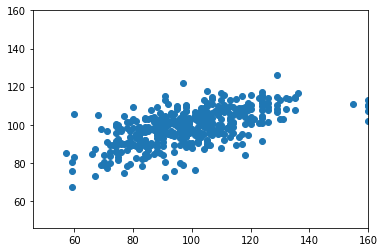

WIAT,WIAT_Word_Stnd
r2:  0.5874547279564175


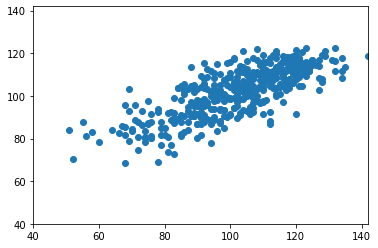

WISC,WISC_FSIQ
r2:  0.6137292309984739


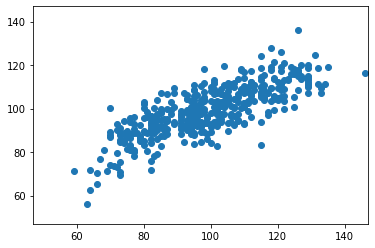

,Output,r2,MAE,Target Score Range (for MAE interpretation)
2,"WISC,WISC_FSIQ",0.61,8.47,"(47.0, 147.0)"
1,"WIAT,WIAT_Word_Stnd",0.59,8.19,"(40.0, 142.0)"
0,"WIAT,WIAT_Num_Stnd",0.36,10.90,"(46.0, 160.0)"


In [34]:
# Check performance of the final model on test set for all models

results_test_set = []
for output in good_performing_outputs:
    estimator = best_estimators[output]
    metrics = get_metrics(estimator, output, input_cols, 'test', 1)
    results_test_set.append([
        output, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Output"] + metric_names)
restults_test_set_df.sort_values(by="r2", ascending=False)

In [37]:
for output in good_performing_outputs:
    print(output)
    print(list(best_estimators[output].named_steps.keys())[-1])
    if list(best_estimators[output].named_steps.keys())[-1] != "randomforestregressor":
        importances = best_estimators[output].named_steps[list(best_estimators[output].named_steps.keys())[-1]].coef_
        importances = pd.DataFrame(zip(train_set.columns, abs(importances)), columns=["Feature", "Importance"])
        pd.set_option('display.precision', 2)
        display(importances.sort_values(by="Importance", ascending=False).iloc[0:10])

WIAT,WIAT_Num_Stnd
elasticnet


,Feature,Importance
960,Diag: Reactive Attachment Disorder,2.88
5,"NIH_Scores,NIH7_List",2.23
971,Diag: Persistent (Chronic) Motor or Vocal Tic Disorder,1.80
2,"NIH_Scores,NIH7_Card",1.60
923,"C3SR,C3SR_33",1.60
743,"PSI,PSI_13",1.38
4,"NIH_Scores,NIH7_Flanker",0.94
1014,Diag: Major Depressive Disorder,0.88
246,"SWAN,SWAN_04",0.85
651,"APQ_SR,APQ_SR_04",0.65


WIAT,WIAT_Word_Stnd
elasticnet


,Feature,Importance
1014,Diag: Major Depressive Disorder,4.09
918,"C3SR,C3SR_28",2.44
743,"PSI,PSI_13",1.90
5,"NIH_Scores,NIH7_List",1.78
971,Diag: Persistent (Chronic) Motor or Vocal Tic Disorder,1.76
898,"C3SR,C3SR_08",1.46
894,"C3SR,C3SR_04",1.07
947,Diag: Excoriation (Skin-Picking) Disorder,0.88
921,"C3SR,C3SR_31",0.83
651,"APQ_SR,APQ_SR_04",0.78


WISC,WISC_FSIQ
elasticnet


,Feature,Importance
5,"NIH_Scores,NIH7_List",3.90
743,"PSI,PSI_13",3.03
2,"NIH_Scores,NIH7_Card",2.18
971,Diag: Persistent (Chronic) Motor or Vocal Tic Disorder,1.85
246,"SWAN,SWAN_04",1.31
960,Diag: Reactive Attachment Disorder,1.26
979,Diag: Sibling Relational Problem,1.21
4,"NIH_Scores,NIH7_Flanker",0.99
947,Diag: Excoriation (Skin-Picking) Disorder,0.92
894,"C3SR,C3SR_04",0.73


### Feature importance

In [38]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-cog-scores-item-lvl.joblib')
    except Exception as e: print(e)

In [39]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["r2"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["r2"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

WIAT,WIAT_Num_Stnd


,r2
1,0.14
2,0.24
3,0.29
4,0.32
5,0.34
...,...
96,0.43
97,0.43
98,0.43
99,0.43


Max score:  0.42735994017195944  at  100  features


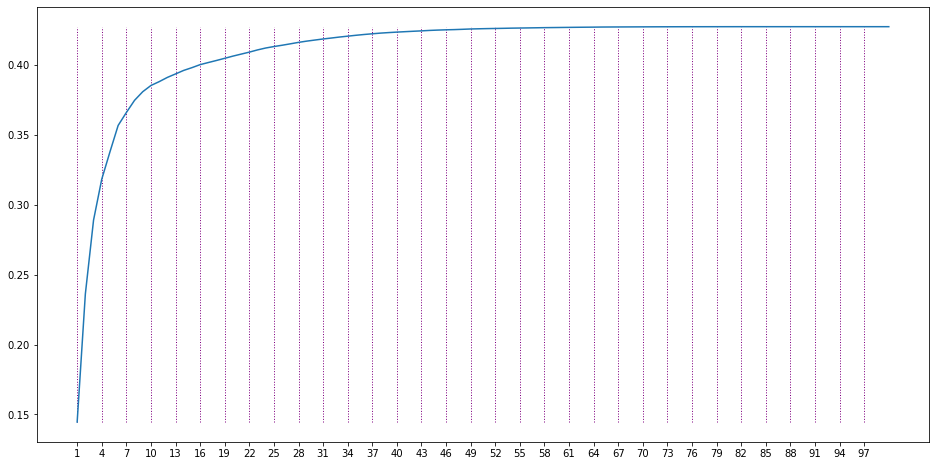

Optimal number of features:  12


('NIH_Scores,NIH7_Card',
 'NIH_Scores,NIH7_List',
 'SWAN,SWAN_06',
 'ICU_P,ICU_P_03',
 'APQ_P,APQ_P_39',
 'ESWAN,DMDD_1B',
 'APQ_SR,APQ_SR_05',
 'PSI,PSI_18',
 'C3SR,C3SR_38',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Intellectual Disability-Mild',
 'Diag: Specific Learning Disorder with Impairment in Reading')

WIAT,WIAT_Word_Stnd


,r2
1,0.27
2,0.37
3,0.44
4,0.49
5,0.51
...,...
96,0.63
97,0.63
98,0.63
99,0.63


Max score:  0.6257189549999878  at  100  features


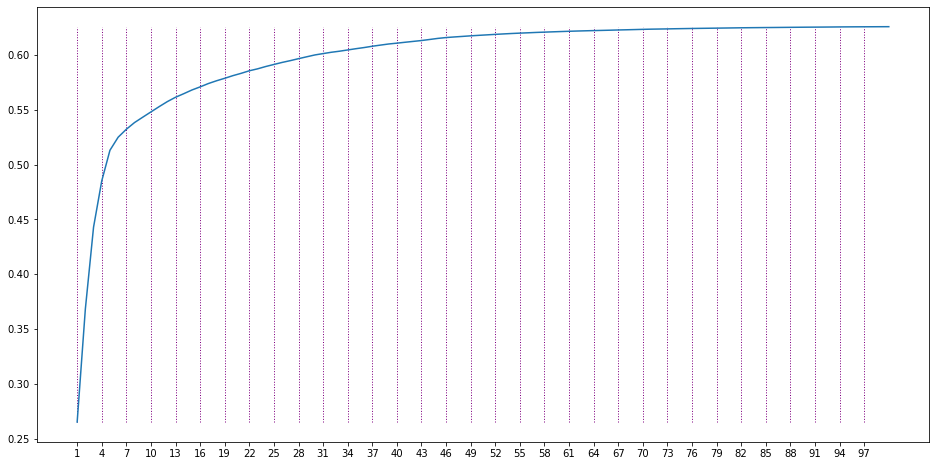

Optimal number of features:  13


('NIH_Scores,NIH7_List',
 'SCQ,SCQ_12',
 'CBCL,CBCL_50',
 'DTS,DTS_06',
 'APQ_SR,APQ_SR_05',
 'PSI,PSI_18',
 'C3SR,C3SR_04',
 'C3SR,C3SR_13',
 'C3SR,C3SR_33',
 'Diag: Borderline Intellectual Functioning',
 'Diag: Intellectual Disability-Mild',
 'Diag: Language Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading')

WISC,WISC_FSIQ


,r2
1,0.30
2,0.41
3,0.46
4,0.48
5,0.51
...,...
96,0.61
97,0.61
98,0.61
99,0.61


Max score:  0.6116495779123775  at  100  features


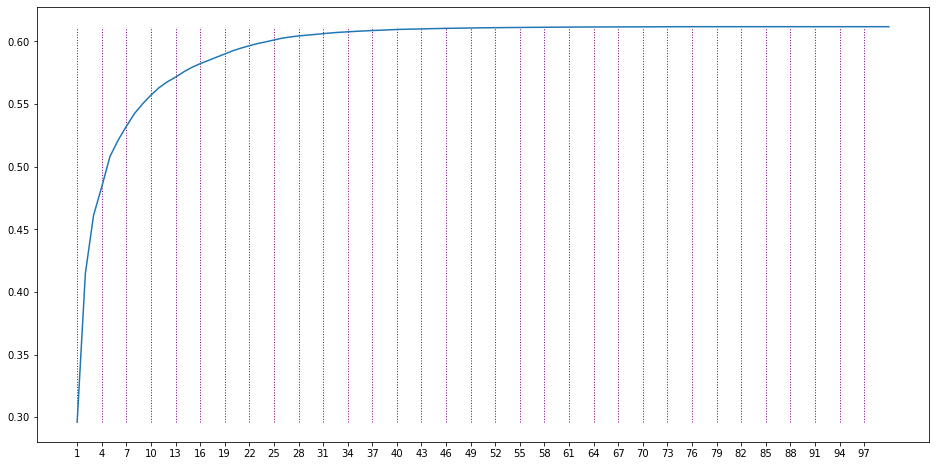

Optimal number of features:  15


('NIH_Scores,NIH7_Card',
 'NIH_Scores,NIH7_Flanker',
 'NIH_Scores,NIH7_List',
 'SCQ,SCQ_39',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'APQ_P,APQ_P_28',
 'ESWAN,MDD_5',
 'PSI,PSI_15',
 'PSI,PSI_18',
 'C3SR,C3SR_09',
 'Diag: Borderline Intellectual Functioning',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Intellectual Disability-Mild',
 'Diag: Language Disorder')

In [40]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for output in good_performing_outputs:
        print(output)
        estimator = best_estimators[output]

        sfs = SequentialFeatureSelector(estimator, 
              k_features=100,
              forward=True, 
              scoring='r2',
              cv=3,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[output])

        forward_feature_subsets[output] = sfs.subsets_
        forward_feature_objects[output] = sfs
        
        analyze_importances(forward_feature_objects[output].subsets_)

In [41]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-cog-scores-item-lvl.joblib', compress=1)

WIAT,WIAT_Num_Stnd


,r2
1,0.14
2,0.24
3,0.29
4,0.32
5,0.34
...,...
96,0.43
97,0.43
98,0.43
99,0.43


Max score:  0.42735994017195944  at  100  features


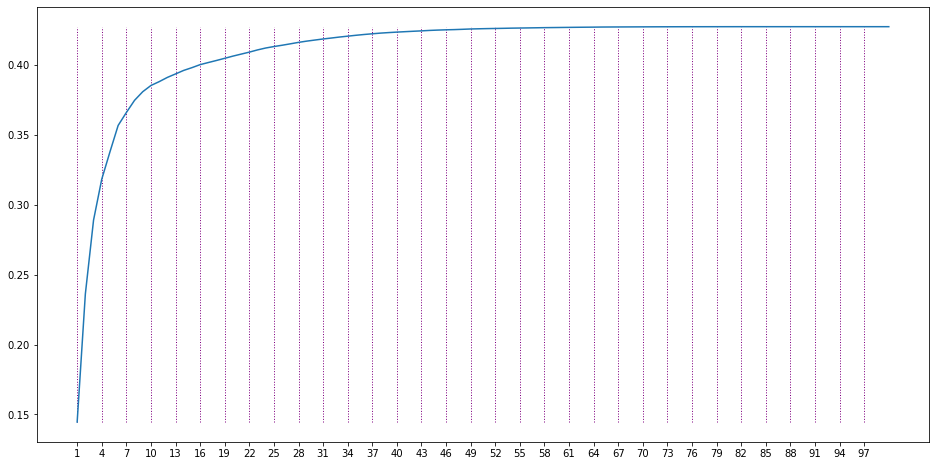

Optimal number of features:  12


('NIH_Scores,NIH7_Card',
 'NIH_Scores,NIH7_List',
 'SWAN,SWAN_06',
 'ICU_P,ICU_P_03',
 'APQ_P,APQ_P_39',
 'ESWAN,DMDD_1B',
 'APQ_SR,APQ_SR_05',
 'PSI,PSI_18',
 'C3SR,C3SR_38',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Intellectual Disability-Mild',
 'Diag: Specific Learning Disorder with Impairment in Reading')

Score using all features: 
WIAT,WIAT_Num_Stnd
r2:  0.3565225073529579


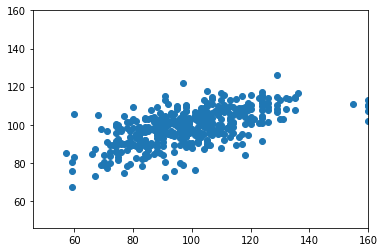

R2:  0.3565225073529579
Performance on test set using optimal number of columns: 
WIAT,WIAT_Num_Stnd
r2:  0.34440791488588196


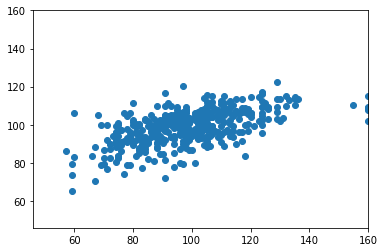

R2:  0.34440791488588196
Performance on test set using number of columns with maximum score
WIAT,WIAT_Num_Stnd
r2:  0.3489778659998106


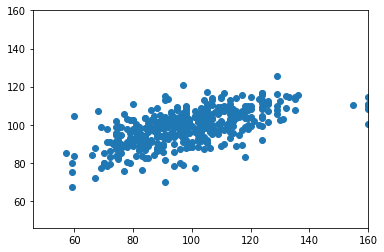

R2:  0.3489778659998106
WIAT,WIAT_Word_Stnd


,r2
1,0.27
2,0.37
3,0.44
4,0.49
5,0.51
...,...
96,0.63
97,0.63
98,0.63
99,0.63


Max score:  0.6257189549999878  at  100  features


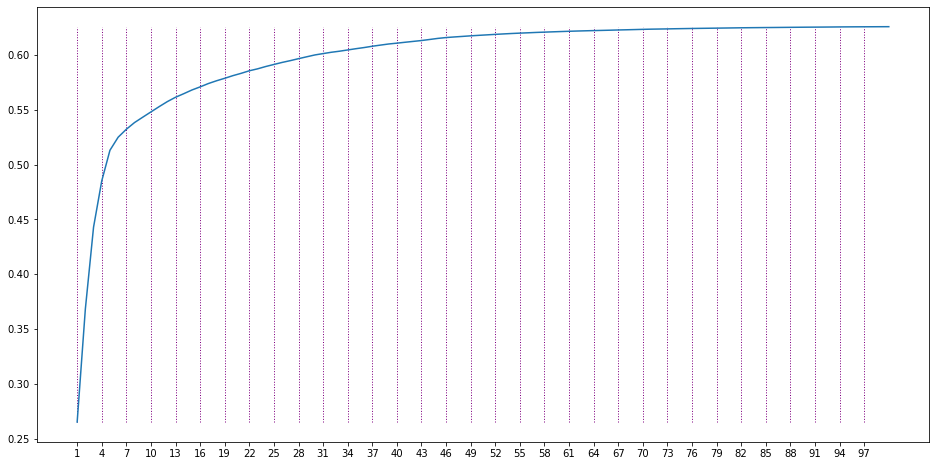

Optimal number of features:  13


('NIH_Scores,NIH7_List',
 'SCQ,SCQ_12',
 'CBCL,CBCL_50',
 'DTS,DTS_06',
 'APQ_SR,APQ_SR_05',
 'PSI,PSI_18',
 'C3SR,C3SR_04',
 'C3SR,C3SR_13',
 'C3SR,C3SR_33',
 'Diag: Borderline Intellectual Functioning',
 'Diag: Intellectual Disability-Mild',
 'Diag: Language Disorder',
 'Diag: Specific Learning Disorder with Impairment in Reading')

Score using all features: 
WIAT,WIAT_Word_Stnd
r2:  0.5874547279564175


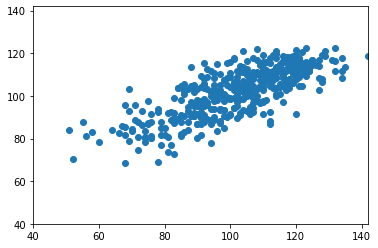

R2:  0.5874547279564175
Performance on test set using optimal number of columns: 
WIAT,WIAT_Word_Stnd
r2:  0.5580317599287332


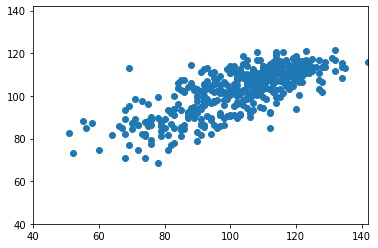

R2:  0.5580317599287332
Performance on test set using number of columns with maximum score
WIAT,WIAT_Word_Stnd
r2:  0.5881986778954524


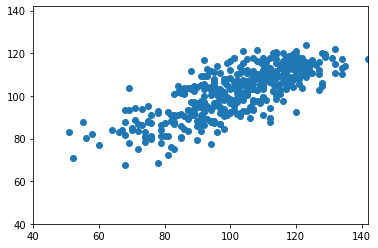

R2:  0.5881986778954524
WISC,WISC_FSIQ


,r2
1,0.30
2,0.41
3,0.46
4,0.48
5,0.51
...,...
96,0.61
97,0.61
98,0.61
99,0.61


Max score:  0.6116495779123775  at  100  features


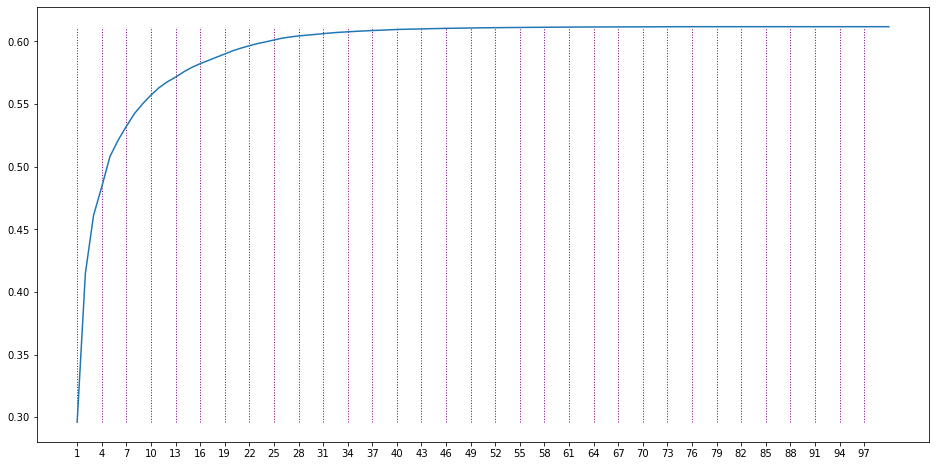

Optimal number of features:  15


('NIH_Scores,NIH7_Card',
 'NIH_Scores,NIH7_Flanker',
 'NIH_Scores,NIH7_List',
 'SCQ,SCQ_39',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'APQ_P,APQ_P_28',
 'ESWAN,MDD_5',
 'PSI,PSI_15',
 'PSI,PSI_18',
 'C3SR,C3SR_09',
 'Diag: Borderline Intellectual Functioning',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Intellectual Disability-Mild',
 'Diag: Language Disorder')

Score using all features: 
WISC,WISC_FSIQ
r2:  0.6137292309984739


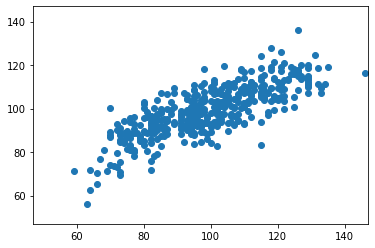

R2:  0.6137292309984739
Performance on test set using optimal number of columns: 
WISC,WISC_FSIQ
r2:  0.5843645660241128


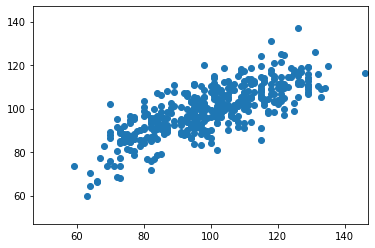

R2:  0.5843645660241128
Performance on test set using number of columns with maximum score
WISC,WISC_FSIQ
r2:  0.608581754908097


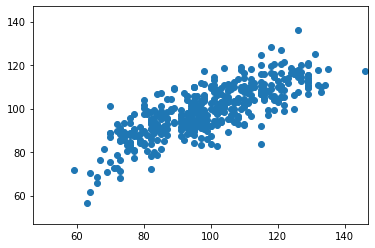

R2:  0.608581754908097


In [42]:
# Print sfs results
for output in good_performing_outputs:
    print(output)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[output].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    estimator = best_estimators[output]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[input_cols], train_set[output])
    print("Score using all features: ")
    metrics = get_metrics(new_estimator, output, input_cols, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_optimal], train_set[output])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_estimator, output, features_up_to_optimal, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_max_score], train_set[output])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_estimator, output, features_up_to_max_score, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])